In [1]:
import numpy as np
import matplotlib.pyplot as plt

EPSILON = 1e-6

# Уравнение
$\frac{\mathrm{d^2}y}{\mathrm{d}x^2} + \frac{0.5}{1-0.5y}(\frac{\mathrm{d}y}{\mathrm{d}x})^2 = 0$  
$ y(0) = y_0;  y(1) = 0$     
$ y_0 = 0.25; 0.5; 1; 1.5; 1.8; 1.9; 1.95 $

Перепишем уравнение в виде системы:  
$ \frac{\mathrm{d}y}{\mathrm{d}x} = u $  
$ \frac{\mathrm{d}u}{\mathrm{d}x} = \frac{u^2}{y-2} $  
$ y(0) = y_0;  y(1) = 0$


In [2]:
def f(t, w):
    y = w[0]
    u = w[1]
    return np.array([u, u**2 / (y-2)])

# Идея
У нас есть уравнение:  
$ y'' = f(x, y, y') $  
$ y(0) = y_0 $  
$ y(L) = y_1 $  
Но вместо этого прекрасного уравнения будем решать немного другую задачу:  
$ y'' = f(x, y, y') $  
$ y(0) = y_0 $  
$ y'(0) = \alpha $  
Далее, решаем эту задачу и получаем решение $y(x,\alpha)$  
Нам надо определить такой параметр $\alpha$, при котором $y(L, \alpha_0) = y_1 $  
Как найти $\alpha0$?  
Нужно решить уравнение $F(\alpha) = y(x, \alpha) - y_1 = 0$. Однако возникают трудности с тем, что $F$ задано не аналитически. Трудности с поиском производной в методе Ньютона  
Что делаем в таком случае?  
Перепишем уравнение в виде системы:  
$u' = f(x, y, u) $  
$y' = u $  
$y(0) = y_0 $  
$u(0) = \alpha $    
Дифференцируем по $\alpha$

$\frac{d}{dx} \left(\frac{\partial u}{\partial \alpha} \right) = \frac{\partial f}{\partial y} \frac{\partial y}{\partial \alpha} + \frac{\partial f}{\partial u} \frac{\partial u}{\partial \alpha} $  
$\frac{d}{dx} \left(\frac{\partial y}{\partial \alpha} \right) = \frac{\partial u}{\partial \alpha} $  
$\frac{\partial y}{\partial \alpha}(0) = 0 $  
$\frac{\partial u}{\partial \alpha}(0) = 1 $  

Делаем замену

$\frac{dA}{dx} = B $    
$\frac{dB}{dx} = A \frac{\partial f}{\partial y} + B \frac{\partial f}{\partial u} $     
$A(0) = 0 $  
$B(0) = 1$  
Решаем эту систему, и теперь можно воспользоваться методом Ньютона:

$\alpha_{n+1} = \alpha_n - \frac{F(\alpha_n)}{\frac{\partial y}{\partial \alpha}(\alpha_n)}$

In [3]:
# Используем метод РК из 6 лабы
def runge_kutta_step(f, h, t, w):

    k1 = f(t, w)
    k2 = f(t + h/2, w + h * k1/2)
    k3 = f(t + h/2, w + h * k2/2)
    k4 = f(t + h, w + h * k3)
    w_new = w + h * (k1 + 2* k2 + 2*k3 + k4) / 6

    return w_new

Решаем систему для $y$ и $u$ и для $A$ и $B$ одновременно

In [4]:
def get_solution(f, h, t0, tn, w0):
    n = int((tn - t0) / h)
     # Initialize arrays for t and w
    t = np.zeros(n+1)
    w = np.zeros((n+1, 2))
    w[0] = w0


    ab = np.zeros((n+1, 2))
    ab[0] = np.array([0, 1])

    for i in range(n):
        w[i+1] = runge_kutta_step(f, h, t[i], w[i])


        yi, ui = w[i]
        df_dy = (-ui**2)/(yi - 2)**2
        df_du = 2*ui / (yi - 2)

        def g(t, ab):
            A = ab[0]
            B = ab[1]
            return np.array([B, A*df_dy + B*df_du])

        ab[i+1] = runge_kutta_step(g, h, t[i], ab[i])
        
        t[i+1] = t[i] + h

    A, B = ab.T
    return (w, A[-1])

И наконец, финальный метод. Ищем $\alpha$

In [5]:
def shooting(f, h, t0, tn, y0, alpha0):
    w0 = np.array([y0, alpha0])

    res = get_solution(f, h, t0, tn, w0)
    w = res[0]
    y, u = w.T

    df = res[1]
    y_L = y[-1]

    prev = 0
    next = alpha0
    
    while (abs(y_L) > EPSILON):
        prev = next
        next = prev - y_L/df
        
        res = get_solution(f, h, t0, tn, np.array([y0, next]))
        y, u = res[0].T

        df = res[1]
        y_L = y[-1]
    
    return y, next

Результаты

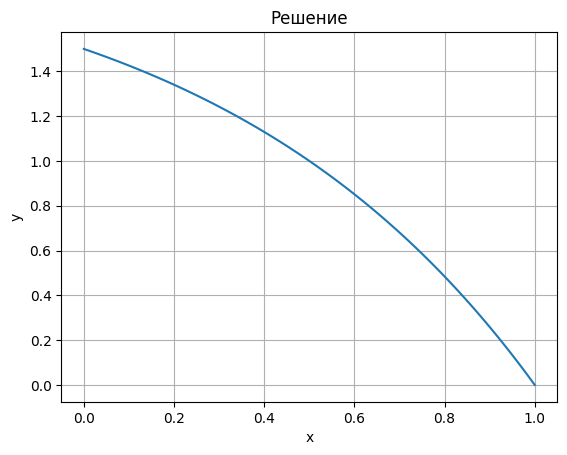

alpha = -0.6931471818264804


In [6]:
x0 = 0
xn = 1
h = 0.01
y0 = 1.5

alpha0 = -1
y, alpha = shooting(f, h, x0, xn, y0, alpha0)

x = np.linspace(x0, xn, int((xn-x0)/h+1))
plt.plot(x, y)
plt.title('Решение')
plt.ylabel('y')
plt.xlabel('x')
plt.grid()
plt.show()
print('alpha = ' + str(alpha))